# CV Chain Test for Capstone Project
##### - Rishik Tiwari (techyrishik@gmail.com)

In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import json
import pickle
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
import PIL
from PIL import Image

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# llm stuff
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
from llama_cpp import Llama

# dino stuff
from groundingdino.util.inference import load_model, load_image, predict, annotate

In [2]:
# Check that MPS is available
device = torch.device("mps")
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ and/or you do not have an MPS-enabled device on this machine.")

else:
    print('MPS is available and active!')
    device = torch.device("mps")

torch.set_default_device(device)

MPS is available and active!


In [3]:
llmModelPath = '/Volumes/Rishik T7_1/AI/mistralChatbot/models/llama2/llama-2-7b-chat.Q4_K_M.gguf'
llm = Llama(
    model_path=llmModelPath,
    n_gpu_layers=-1,
    temperature=0.5,
    top_k=40,
    top_p=0,
    repeat_penalty=1.1764705882352942,
    n_batch=1024,
    n_ctx=1024,
    chat_format='llama-2'
);

llama_model_loader: loaded meta data with 19 key-value pairs and 291 tensors from /Volumes/Rishik T7_1/AI/mistralChatbot/models/llama2/llama-2-7b-chat.Q4_K_M.gguf (version GGUF V2)
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = LLaMA v2
llama_model_loader: - kv   2:                       llama.context_length u32              = 4096
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:                  llama.feed_forward_length u32              = 11008
llama_model_loader: - kv   6:                 llama.rope.dimension_count u32              = 128
llama_model_loader: - kv   7:          

llama_model_loader: - kv  13:                      tokenizer.ggml.scores arr[f32,32000]   = [0.000000, 0.000000, 0.000000, 0.0000...
llama_model_loader: - kv  14:                  tokenizer.ggml.token_type arr[i32,32000]   = [2, 3, 3, 6, 6, 6, 6, 6, 6, 6, 6, 6, ...
llama_model_loader: - kv  15:                tokenizer.ggml.bos_token_id u32              = 1
llama_model_loader: - kv  16:                tokenizer.ggml.eos_token_id u32              = 2
llama_model_loader: - kv  17:            tokenizer.ggml.unknown_token_id u32              = 0
llama_model_loader: - kv  18:               general.quantization_version u32              = 2
llama_model_loader: - type  f32:   65 tensors
llama_model_loader: - type q4_K:  193 tensors
llama_model_loader: - type q6_K:   33 tensors
llm_load_vocab: special tokens definition check successful ( 259/32000 ).
llm_load_print_meta: format           = GGUF V2
llm_load_print_meta: arch             = llama
llm_load_print_meta: vocab type       = SPM
llm_load

In [3]:
# detectron2 config
cfg = get_cfg()
cfg.MODEL.DEVICE = "cpu"

# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model

# Find a model from detectron2's model zoo. https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

[04/25 04:04:30 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


In [4]:
# to show detectron annotations
def showAnnotatedImg(img, outputs):
    v = Visualizer(img, MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    return Image.fromarray(out.get_image()[:,:,::-1]) #bgr to rgb

In [5]:
rgbVid = cv.VideoCapture('./media/pickPlaceTask_ball_zdiff--rgb.mp4')
# depthVid = cv.VideoCapture('./media/pickPlaceTask_ball_zdiff--depth.mp4')
depthVid = None
with open('./media/pickPlaceTask_ball_zdiff--depth.pkl', 'rb') as fileHandle:
    depthVid = pickle.load(fileHandle, encoding='latin1')

print(f'Total frames rgb: {rgbVid.get(cv.CAP_PROP_FRAME_COUNT)}, depth: {len(depthVid)}')

Total frames rgb: 1101.0, depth: 1171


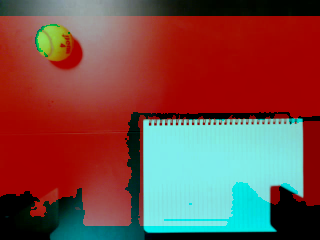

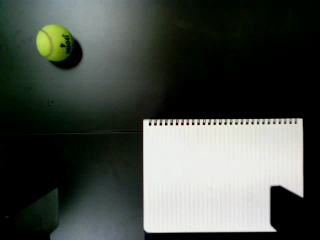

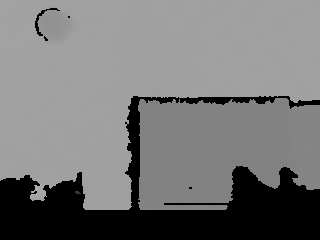

In [6]:
frameNumber = 50

rgbVid.set(cv.CAP_PROP_POS_FRAMES, frameNumber-1)
# depthVid.set(cv.CAP_PROP_POS_FRAMES, frameNumber-1)

(rgbFlag, rgbFrame) = rgbVid.read()
# (depthFlag, depthFrame) = depthVid.read()
depthFrame = depthVid[frameNumber-12] # offset for approx time shift

depthFrameNormalised = np.nan_to_num(depthFrame, copy=True, nan=0.0, posinf=1.0, neginf=0.0)
depthFrameNormalised = (depthFrameNormalised * 255).round().astype(np.uint8)

# reshape from WxH to WxHxC
depthFrameNormalised = np.reshape(depthFrameNormalised, (depthFrameNormalised.shape[0], depthFrameNormalised.shape[1], 1))

rgbFrameImg = None
depthFrameImg = None
depthYOffset = 16 # y-offset to align depth image

if rgbFlag:
    rgbFrame = cv.resize(rgbFrame, (320, 240))
    # depthFrame = cv.resize(depthFrame, (320, 240))
    rgbFrameImg = Image.fromarray(rgbFrame[:,:,::-1], mode='RGB') #BGR to RGB
    depthFrameImg = Image.fromarray(depthFrameNormalised[:,:,0], mode='L')
    
    overlayed = rgbFrame[:,:,::-1].copy()
    overlayed[depthYOffset:overlayed.shape[0], :, 0] = depthFrameNormalised[:depthFrameNormalised.shape[0]-depthYOffset, :, 0]
    overlayImg = Image.fromarray(overlayed)
    
    display(overlayImg, rgbFrameImg, depthFrameImg)
else:
    print('Could not extract video frame!')


{'instances': Instances(num_instances=1, image_height=240, image_width=320, fields=[pred_boxes: Boxes(tensor([[35.7012, 24.1951, 73.5221, 62.5682]])), scores: tensor([0.9906]), pred_classes: tensor([32]), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]]])])}


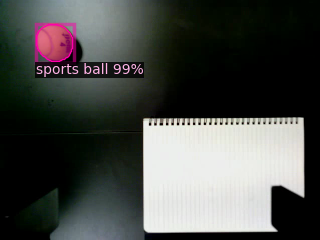

In [8]:
# run detectron2 inference
outputs = predictor(rgbFrame)
print(outputs)

showAnnotatedImg(rgbFrame, outputs)

In [182]:
#run llm inference - Llama CPP
def inferTask(taskMsg):
    systemInstruct = '''
    Your job is to extract action and objects from the given task. Respond only in JSON format.
    \nDo not comment, explain, or elaborate your thought processes. Your response should have two keys: actions and objects. Split the task in as many as sub-actions possible. Only mention the name of object.
    \n
    \nExample 1:
    \nTask: Pick up the cookie and place it on the tiffin box.
    \nAnswer: { "actions": ["pick_up", "place"], objects: ["cookie", "tiffin box"] }
    '''
    userMsg = 'Task: ' + str.strip(taskMsg)

    llmOutput = llm.create_chat_completion(
        messages = [
            {"role": "system", "content": systemInstruct},
            {
                "role": "user",
                "content": userMsg
            }
        ],
        # stop=["<|endoftext|>"]
    )

    return str.strip(llmOutput['choices'][0]['message']['content'])

In [183]:
def getLlmIntel(taskMsg: str):
    isSatisfiableLlmOutput = False
    llmAttemptCounter = 0
    llmIntel = None

    while ((isSatisfiableLlmOutput == False) and (llmAttemptCounter == 5)):
        llmAttemptCounter += 1
        llmIntel = inferTask(taskMsg)
        if llmIntel:
            try:
                llmIntel = json.loads(llmIntel)
                isSatisfiableLlmOutput = True
                break
            except: pass

    if not isSatisfiableLlmOutput:
        print('Could not get a satisfiable answer from llm.')
        llmIntel = {"actions": False}

    print(f'Got LLM intel in {llmAttemptCounter} attempts.')
    print(llmIntel)
    return llmIntel

In [184]:
llmIntel = getLlmIntel('Pickup the ball and place it on the white paper')


llama_print_timings:        load time =   19379.41 ms
llama_print_timings:      sample time =       2.37 ms /    26 runs   (    0.09 ms per token, 10961.21 tokens per second)
llama_print_timings: prompt eval time =   19378.80 ms /   160 tokens (  121.12 ms per token,     8.26 tokens per second)
llama_print_timings:        eval time =     922.18 ms /    25 runs   (   36.89 ms per token,    27.11 tokens per second)
llama_print_timings:       total time =   20340.19 ms /   185 tokens
Llama.generate: prefix-match hit

llama_print_timings:        load time =   19379.41 ms
llama_print_timings:      sample time =       2.38 ms /    25 runs   (    0.10 ms per token, 10495.38 tokens per second)
llama_print_timings: prompt eval time =       0.00 ms /     1 tokens (    0.00 ms per token,      inf tokens per second)
llama_print_timings:        eval time =     917.98 ms /    25 runs   (   36.72 ms per token,    27.23 tokens per second)
llama_print_timings:       total time =     959.36 ms /    26 

Got LLM intel in 2 attempts.
{'actions': ['pick_up', 'place'], 'objects': ['ball', 'white paper']}


### Loading and passing to GroundingDINO

In [9]:
gdinoModel = load_model('groundingdino/config/GroundingDINO_SwinT_OGC.py', 'gDinoWeights/groundingdino_swint_ogc.pth')

final text_encoder_type: bert-base-uncased


In [10]:
import groundingdino.datasets.transforms as T

def loadImgForGDino(img: Image.Image):
    transform = T.Compose(
        [
            T.RandomResize([800], max_size=1333),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]
    )
    image_source = img.convert("RGB")
    image = np.asarray(image_source)
    image_transformed, _ = transform(image_source, None)
    return image, image_transformed

In [11]:
TEXT_PROMPT = 'green ball .'
#TEXT_PROMPT = ' . '.join(llmIntel['objects']) + ' .' # all llmIntel objects are joined by dot
BOX_TRESHOLD = 0.35
TEXT_TRESHOLD = 0.25

rgbImg_source, rgbImg = loadImgForGDino(rgbFrameImg)
print('DINO prompt: %s' % TEXT_PROMPT)

DINO prompt: green ball .


In [12]:
dino_boxes, dino_logits, dino_phrases = predict(
    model=gdinoModel,
    image=rgbImg,
    caption=TEXT_PROMPT,
    box_threshold=BOX_TRESHOLD,
    text_threshold=TEXT_TRESHOLD,
    device="cpu"                #NOTE: cpu and mps have different predictions
)

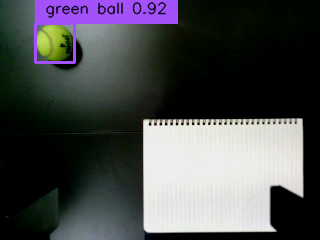

In [13]:
annotated_dino_frame = annotate(image_source=rgbImg_source, boxes=dino_boxes, logits=dino_logits, phrases=dino_phrases)

# show annotated image, convert BGR to RGB by reversing the order
Image.fromarray(annotated_dino_frame[:,:,::-1], mode="RGB")

SupervisionWarnings: BoxAnnotator is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


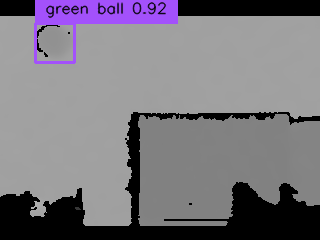

In [10]:
# exaggeratedDepthImg = np.asarray(depthFrameImg)*10
# cv.normalize(exaggeratedDepthImg, exaggeratedDepthImg, 0, 255, cv.NORM_MINMAX)

depthFrameNormAligned = np.zeros_like(depthFrameNormalised)
depthFrameNormAligned[depthYOffset:depthFrameNormAligned.shape[0], :, 0] = depthFrameNormalised[:depthFrameNormalised.shape[0]-depthYOffset, :, 0]

annotated_dino_depthframe = annotate(image_source=depthFrameNormAligned, boxes=dino_boxes, logits=dino_logits, phrases=dino_phrases)

# show annotated image, convert BGR to RGB by reversing the order
Image.fromarray(annotated_dino_depthframe[:,:,::-1], mode="RGB")

In [11]:
(h, w) = rgbImg_source.shape[:2]

# the boxes value is in format: cxcywh - box center x, center y, width, height
normalised_bboxes = np.round(np.array(dino_boxes * torch.Tensor([w, h, w, h]), dtype=np.uint8), decimals=0)
print(normalised_bboxes)

[[54 42 39 39]]


Object: green ball, Mid: 34.3cm, Mean: 37.1cm


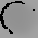

In [12]:
mean_depths = []
mid_depths = []
GRIPPER_LENGTH_CM = 22.5

for i in range(len(normalised_bboxes)):
    (cx, cy, w, h) = normalised_bboxes[i][:]
    cy -= depthYOffset      # shifts detection center by yOffset to align correctly
    w = w//2
    h = h//2
    mean_depth = np.array(depthFrame[cy-h:cy+h, cx-w:cx+w]).copy()
    mean_depth = mean_depth[~np.isnan(mean_depth)]
    mean_depth = np.mean(mean_depth) * 100 - GRIPPER_LENGTH_CM
    mean_depths.append(mean_depth)
    mid_depth = depthFrame[cy, cx] * 100 - GRIPPER_LENGTH_CM
    mid_depths.append(mid_depth)
    print('Object: %s, Mid: %.1fcm, Mean: %.1fcm' % (dino_phrases[i], mid_depth, mean_depth))
    display(Image.fromarray(depthFrameNormalised[cy-h:cy+h, cx-w:cx+w, 0]))

In [13]:
print(mid_depths)

[34.32143568992615]


240 320
-0.05 0.05 0


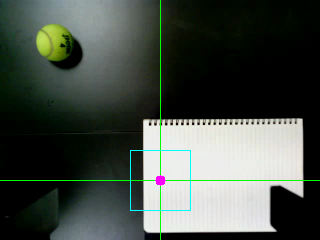

: 

In [59]:
def objDistTest(img, bbox):
    (cx, cy, bw, bh) = bbox[:]
    img = img.copy()
    colour = (0, 255, 0)
    (h, w, _) = img.shape
    tolPx = 30

    print(h, w)
    mx = (h//4)*3   # shift mid point to lower half near the gripper
    my = w//2

    cv.line(img, (0, mx), (w, mx), colour, 1) # horz
    cv.line(img, (my, 0), (my, h), colour, 1) # vert

    cv.rectangle(img, (my-tolPx, mx-tolPx), (my+tolPx, mx+tolPx), color=(0,255,255), thickness=1) # tolerance region
    cv.circle(img, (my, mx), radius=5, color=(255,0,255), thickness=-1) # required mid point

    stepx = 0
    stepy = 0
    stepz = 0

    if(cx > mx):
        stepx = 0.05
    elif(cx < mx):
        stepx = -0.05
    
    if(cy > my):
        stepy = -0.05
    elif(cy < my):
        stepy = 0.05

    print(stepx, stepy, stepz)

    return img

display(Image.fromarray( objDistTest(rgbImg_source, normalised_bboxes[0]) ))

In [14]:
def draw_grid(img, grid_shape, color=(0, 255, 0), thickness=1):
    img = img.copy()
    h, w, _ = img.shape
    rows, cols = grid_shape
    dy, dx = h / rows, w / cols

    # draw vertical lines
    for x in np.linspace(start=dx, stop=w-dx, num=cols-1):
        x = int(round(x))
        cv.line(img, (x, 0), (x, h), color=color, thickness=thickness)

    # draw horizontal lines
    for y in np.linspace(start=dy, stop=h-dy, num=rows-1):
        y = int(round(y))
        cv.line(img, (0, y), (w, y), color=color, thickness=thickness)

    return img

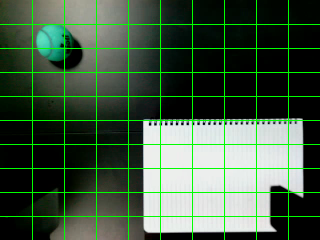

In [15]:
display(Image.fromarray(draw_grid(rgbFrame, (10,10))))

In [16]:
def drawARGrid(img, distance):
    img = img.copy()
    h, w, _ = img.shape
    colour = (0,255,0)

    line1X = round((w/2) - (w/4) + distance, ndigits=None)
    line2X = round((w/2) + (w/4) - distance, ndigits=None)
    line3Y = round((h/2) - (h/4) + distance, ndigits=None)
    line4Y = round((h/2) + (h/4) - distance, ndigits=None)
    
    cv.line(img, (line1X, 0), (line1X, h), colour, 1)
    cv.line(img, (line2X, 0), (line2X, h), colour, 1)
    cv.line(img, (0, line3Y), (w, line3Y), colour, 1)
    cv.line(img, (0, line4Y), (w, line4Y), colour, 1)
    cv.putText(img, str(round(distance, 1))+'cm', (4, h-4), cv.FONT_HERSHEY_PLAIN, 1, colour, 1)

    return img


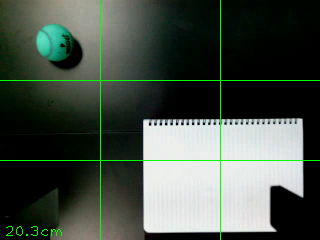

In [17]:
display(Image.fromarray(drawARGrid(rgbFrame, 20.27638)))

In [18]:
# experimenting with superimposing and tracking a grid based on depth
cv.namedWindow('rgb')
cv.setWindowProperty('rgb', cv.WND_PROP_TOPMOST, 1)

for i in range(200, 300):
    rgbVid.set(cv.CAP_PROP_POS_FRAMES, i-1)
    # depthVid.set(cv.CAP_PROP_POS_FRAMES, i-1)

    (rgbFlag, rgbFrame) = rgbVid.read()
    # (depthFlag, depthFrame) = depthVid.read()

    if rgbFlag:
        rgbFrame = cv.resize(rgbFrame, (320, 240))
        # depthFrame = cv.resize(depthFrame, (320, 240))
        # dist = round(np.mean((depthFrame**5)*10), ndigits=None) + 1
        dist = depthVid[i][160][120]*100 - 22.5
        # print(dist)
        # gridFrame = draw_grid(rgbFrame, (dist, dist))
        gridFrame = drawARGrid(rgbFrame, dist)
        
        cv.imshow('rgb', gridFrame)
        cv.waitKey(1)
    sleep(0.033)

cv.destroyAllWindows()
cv.waitKey(1)

-1